# Generating Images of Digits from Text Prompts

This notebook provides you with a complete code example to generate MNIST digits from text prompts. The `train_text_prompts.txt` and `test_text_prompts.txt` files provide the text data used for training and testing.

## Loading the MNIST Dataset with PyTorch

Implement the normalization of the digits ...

In [1]:
from torchvision.transforms import Compose, Normalize, ToTensor

trans = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5], inplace=True)])

... import the MNIST digits ...

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=trans, download=True)

... and plot some of the transformed MNIST digits.

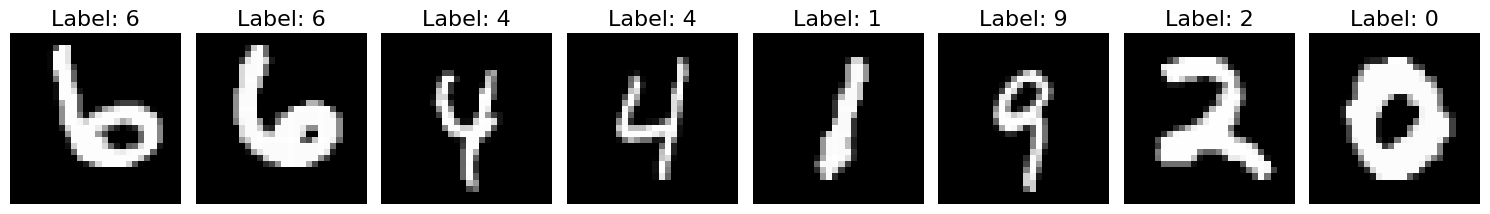

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
    img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}", fontsize=16)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Forward Process

Define the device on which the computations are performed ...

In [4]:
import torch

def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [5]:
device = get_device()

In [6]:
print(device)

mps


... implement the forward diffusion process ...

In [7]:
class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 device=device):
        """Initialize the diffusion model."""
        self.noise_steps, self.beta_start, self.beta_end, self.device = \
            noise_steps, beta_start, beta_end, device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

... sampling images in the forward diffusion process ..

In [8]:
diffusion = Diffusion(noise_steps=401, beta_start=0.0001, beta_end=0.02)

clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

time_steps = [0, 100, 200, 300, 400]
noisy_images = []
for i in range(len(time_steps)):
    noisy_image, noise = diffusion.forward_diffusion(
        x=clean_image[None, ...].to(device), 
        t=torch.tensor([time_steps[i]]).to(device)
    )
    noisy_images.append(noisy_image)

... and visualize the noisy digits generated in the forward diffusion process.

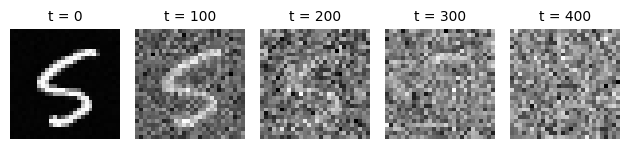

In [9]:
fig, axs = plt.subplots(1, len(time_steps))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"t = {time_steps[i]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Reverse Diffusion Process

Update the `Diffusion` class to implement the reverse diffusion process.

In [10]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 img_size=28, device=device):
        """Initialize the diffusion model."""
        self.noise_steps, self.beta_start, self.beta_end, self.device = \
            noise_steps, beta_start, beta_end, device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
        self.img_size = img_size

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def reverse_diffusion(self, model, n_images, n_channels, 
                          position_encoding_dim, position_encoding_function,
                          fix_noise=None, save_time_steps=None, 
                          context=None, guidance_strength=None):
        """Reverse diffusion process"""
        with torch.no_grad():
            if fix_noise is not None:
                x = fix_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                ).to(self.device)
            
            denoised_images = []
            for i in tqdm(reversed(range(0, self.noise_steps)),
                          desc="U-Net inference", total=self.noise_steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = position_encoding_function(
                    t.unsqueeze(1), position_encoding_dim
                ).to(self.device)

                if context is None:
                    predicted_noise = model(x=x, t=t_pos_enc)
                else:
                    conditional_pred = model(x=x, t=t_pos_enc, context=context)
                    unconditional_pred = model(x=x, t=t_pos_enc, context=None)
                    predicted_noise = torch.lerp(unconditional_pred,
                                                 conditional_pred,
                                                 guidance_strength)

                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                    
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                    / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                    + torch.sqrt(1-alpha) * noise)

                if i in save_time_steps: denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Preparing the Text Prompts

Load the text prompts ...

In [11]:
train_text_prompts = []
with open("train_text_prompts.txt", "r") as f:
    for line in f: train_text_prompts.append(line.strip())

test_text_prompts = []
with open("test_text_prompts.txt", "r") as f:
    for line in f: test_text_prompts.append(line.strip())

In [12]:
for text_prompt in train_text_prompts: print(text_prompt)

Generate the digit {class_label}.
Create a sample of the number {class_label}.
Show me a picture of the digit {class_label}.
Produce the handwritten digit {class_label}.
Please generate a grayscale image of the number {class_label}.
Kindly create the digit {class_label} in a 28x28 resolution.
I'd like to see the number {class_label} in bold font style.
Show me the digit {class_label} in a slanted appearance.
Generate the digit {class_label} with smooth curves.
Create the number {class_label} with sharp edges.
Show me an enhanced image of the digit {class_label}.
Generate a blurry version of the digit {class_label}.
Create an artistic representation of the number {class_label}.
Show me the digit {class_label} as if drawn by a child.
Generate the digit {class_label} with a serif font style.
Create the number {class_label} with consistent stroke thickness.
Show me the digit {class_label} in a tilted orientation.
Generate the digit {class_label} with added noise.
Create the number {class_l

In [13]:
for text_prompt in test_text_prompts: print(text_prompt)

{class_label} individuals are attending a play in a theater that seats eight. How many people are in the theater?
There are six types of flowers in the garden, and {class_label} are roses. How many flowers are roses?
{class_label} students passed the math test out of nine who took it. How many students succeeded?
In a parking lot, {class_label} out of eight vehicles are vans. How many vans are parked?
During a survey, {class_label} out of nine respondents said they enjoy gardening. How many participants enjoy gardening?
A chef makes nine dishes, and {class_label} are vegetarian. How many dishes are vegetarian?
Eight people finished their tasks, and {class_label} were volunteers. How many volunteers completed their tasks?
A group of tourists visits a national park, and {class_label} of them are seniors. How many seniors are visiting?
{class_label} out of nine poets read their poems live. How many poets read their poems?
Out of nine players, {class_label} play chess. How many chess playe

... implement a function to generate text prompts from given class labels ...

In [14]:
import inflect, random

numbers = {i: inflect.engine().number_to_words(i) for i in range(10)}

def generate_text_prompts(class_labels, text_inputs):
    """Generate text prompts."""
    texts = []
    for i in class_labels:
        if random.random() > 0.3:
            prompt = random.choice(text_inputs).format(class_label=numbers[i])
        else:
            prompt = random.choice(text_inputs).format(class_label=str(i))
        texts.append(prompt)
    return texts

... and generate and print some example text prompts.

In [15]:
class_labels = random.sample(list(range(10)), 4)
example_text_prompts = generate_text_prompts(class_labels, test_text_prompts)
for text_prompt in example_text_prompts: print(text_prompt)

Design a zero with artistic accents.
Generate an image of a eight with trendy graphics.
A library has seven sections and 6 are for fiction books. How many sections are for fiction books?
Produce a fashionable depiction of a three.


## Defining the Position Encoding Function

Implement the position encoding function ...

In [16]:
def positional_encoding(t, enc_dim):
    """Encode position information with a sinusoid."""
    scaled_positions = torch.arange(0, enc_dim, 2).float() / enc_dim
    frequency = 10000 ** scaled_positions
    inverse_frequency = (1.0 / frequency).to(t.device)
    x = t.repeat(1, enc_dim // 2) * inverse_frequency
    pos_enc_a, pos_enc_b = torch.sin(x), torch.cos(x)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

... sinusoidal position encodings for different time steps ...

In [17]:
position_encoding_dim = 256

pos_encs = []
for i in range(0, 100):
    t = torch.tensor([i])
    pos_enc = positional_encoding(t, position_encoding_dim)
    pos_encs.append(pos_enc.squeeze())
pos_encs = torch.stack(pos_encs)

... and visualize the position encodings.

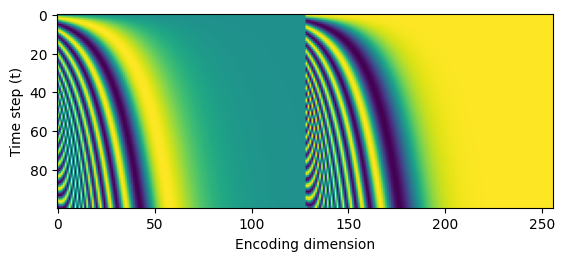

In [18]:
fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Encoding dimension")
plt.ylabel("Time step (t)")
plt.show()

## Defining a Custom Tokenizer and Text Encoder

Implement the function to tokenize the text ...

In [19]:
import contractions, re
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def tokenize(text):
    """Tokenize text."""
    text = contractions.fix(text)
    replacements = {"’": "'", "‘": "'", "“": '"', "”": '"', "´": "'", "´´": '"'}
    for old, new in replacements.items():
        text = text.replace(old, new)
    tokens = tokenizer(text)
    filtered_tokens = [
        token for token in tokens
        if re.match(r"^[a-zA-Z0-9]+(-[a-zA-Z0-9]+)*(_[a-zA-Z0-9]+)*$", token)
    ]
    return filtered_tokens

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


... build a custom vocabulary ...

In [20]:
from torchtext.vocab import build_vocab_from_iterator

def token_iterator(texts):
    """Iterate on tokens."""
    for text in texts:
        yield tokenize(text)

digits_and_words = [str(item) for item in list(numbers.keys()) 
                    + list(numbers.values())]

vocab = build_vocab_from_iterator(
    token_iterator(train_text_prompts + test_text_prompts + digits_and_words),
    specials=["<unk>", "<sos>", "<eos>", "<pad>"],
)    
vocab.set_default_index(vocab["<unk>"])

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


... check the vocabulary and string-to-numerical indices mapping ...

In [21]:
vocab_dict = vocab.get_stoi()
vocab_dict = dict(sorted(vocab_dict.items(), key=lambda item: item[1]))
for word, index in vocab_dict.items(): print(f"{word}: {index}")

<unk>: 0
<sos>: 1
<eos>: 2
<pad>: 3
a: 4
are: 5
of: 6
the: 7
how: 8
many: 9
with: 10
in: 11
and: 12
digit: 13
nine: 14
generate: 15
create: 16
an: 17
me: 18
show: 19
out: 20
number: 21
image: 22
on: 23
there: 24
produce: 25
at: 26
four: 27
seven: 28
six: 29
eight: 30
five: 31
style: 32
artistic: 33
depiction: 34
has: 35
people: 36
regularly: 37
seats: 38
students: 39
design: 40
it: 41
park: 42
representation: 43
their: 44
three: 45
during: 46
illustration: 47
individuals: 48
lot: 49
parked: 50
parking: 51
participants: 52
passed: 53
playing: 54
respondents: 55
said: 56
succeeded: 57
survey: 58
that: 59
they: 60
took: 61
vehicles: 62
who: 63
active: 64
athletes: 65
attending: 66
book: 67
chapters: 68
colors: 69
competing: 70
cover: 71
craft: 72
events: 73
exam: 74
focus: 75
font: 76
group: 77
intricate: 78
kinds: 79
learners: 80
modern: 81
resting: 82
sections: 83
theater: 84
them: 85
to: 86
total: 87
tourists: 88
vegetables: 89
version: 90
visiting: 91
visits: 92
while: 93
work: 94
abs

... write a function to implemet a custom text toknizer ...

In [22]:
def custom_tokenizer(texts, vocab=vocab, max_token_length=77):
    """Tokenize a sentence."""
    batch_tokens = []
    for text_prompt in texts:
        tokens = ([vocab["<sos>"]] + 
                  [vocab[token] for token in tokenize(text_prompt)] + 
                  [vocab["<eos>"]])

        if len(tokens) > max_token_length:
            tokens = tokens[:max_token_length]
        else:
            tokens += [vocab["<pad>"]] * (max_token_length - len(tokens))
        
        tokens = torch.tensor(tokens, dtype=torch.long)
        batch_tokens.append(tokens)
    return torch.stack(batch_tokens)

... observe a tokenized version of an example text prompt ...

In [23]:
class_labels = random.sample(list(range(10)), 1)
example_text = generate_text_prompts(class_labels, train_text_prompts)
tokens = custom_tokenizer(example_text)
print(example_text), print(tokens.shape), print(tokens);

['Generate the digit 0 with smooth curves.']
torch.Size([1, 77])
tensor([[  1,  15,   7,  13, 217,  10, 405, 281,   2,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3]])


... implement a class for a custom text encoder ...

In [24]:
import torch.nn as nn

class TextEncoder(nn.Module):
    """Text encoder."""

    def __init__(self, max_token_length, vocab_size, embedding_dim, num_heads):
        """Initialize the text encoder module."""
        super(TextEncoder, self).__init__()
        
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_encoding = positional_encoding(
            torch.arange(0, max_token_length).unsqueeze(1), embedding_dim,
        )

        self.self_attention = nn.MultiheadAttention(
            embedding_dim, num_heads=num_heads, batch_first=True,
        )
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim), nn.GELU(),
            nn.Linear(embedding_dim, embedding_dim),
        )

    def forward(self, tokens):
        """Forward pass of text encoder module."""
        token_embeddings = self.token_embedding(tokens)
        position_encodings = (self.position_encoding
                              .repeat(tokens.size(0), 1, 1).to(tokens.device))

        token_embeddings_with_pos = token_embeddings + position_encodings

        normalized_embeddings = self.layer_norm1(token_embeddings_with_pos)
        attention_output, _ = self.self_attention(
            query=normalized_embeddings, 
            key=normalized_embeddings, 
            value= normalized_embeddings,
        )
        attention_output = attention_output + normalized_embeddings

        residual_input = attention_output
        normalized_attention_output = self.layer_norm2(attention_output)
        feed_forward_output = self.feed_forward(normalized_attention_output)
        residual_output = feed_forward_output + residual_input

        return residual_output

... instantiate a custom text encoder ...

In [25]:
custom_text_encoder = TextEncoder(max_token_length=77, vocab_size=len(vocab),
                                  embedding_dim=768, num_heads=4).to(device)

... and check the shape of example text prompts.

In [26]:
class_labels = random.sample(list(range(10)), 4)
example_texts = generate_text_prompts(class_labels, train_text_prompts)
tokens = custom_tokenizer(example_texts)
text_embedding = custom_text_encoder(tokens.to(device))

print(f"tokens shape: {tokens.shape}")
print(f"text embeddings shape: {text_embedding.shape}")

tokens shape: torch.Size([4, 77])
text embeddings shape: torch.Size([4, 77, 768])


## Defining the Conditional Attention U-Net

In [27]:
import deeplay as dl

position_encoding_dim = 256
context_embedding_dim = 768

unet = dl.AttentionUNet(
    in_channels=1, channels=[32, 64, 128], base_channels=[256, 256], 
    channel_attention=[True, True, True], out_channels=1, 
    position_embedding_dim=position_encoding_dim, num_classes=10,
    context_embedding_dim=context_embedding_dim,
)
unet.build()
unet.to(device);

print(unet)

AttentionUNet(
  (class_embedding): Embedding(10, 256)
  (encoder): UNetEncoder(
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (blocks): LayerList(
          (0): Block(
            (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
            (activation): GELU(approximate='none')
          )
          (1): Block(
            (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
            (activation): GELU(approximate='none')
          )
        )
        (res_block): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
        (feed_forward_position_embedding): Linear(in_features=256, out_features=32, bias=True)
        (attention_layer): AttentionBlock(
          (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (self_attention): MultiheadAttention(
 

## Training the Diffusion Model

Define the data loader ...

In [28]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)

... define the loss function ...

In [29]:
criterion = torch.nn.MSELoss()

... define the optimizer ...

In [30]:
optimizer = torch.optim.AdamW(list(unet.parameters())
                              + list(custom_text_encoder.parameters()), 
                              lr=1e-4)

...  instantiate the diffusion class for training ...

In [31]:
diffusion = Diffusion(
    noise_steps=1000, img_size=28, beta_start=1e-4, beta_end=0.02,
)

...implement a function to prepare the data ...

In [32]:
def prepare_data(image, noise_steps=1000, device=device):
    """Prepare data."""
    batch_size = image.shape[0]
    t = torch.randint(low=0, high=noise_steps, size=(batch_size,)).to(device)
    image = image.to(device)
    x_t, noise = diffusion.forward_diffusion(image, t)
    t = positional_encoding(t.unsqueeze(1), position_encoding_dim)
    return x_t.to(device), t.to(device), noise.to(device)

... implement the training cycle ...

In [33]:
import numpy as np
import time
from datetime import timedelta

epochs = 20
n_images = 10
save_time_steps = [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]

train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    num_batches = len(loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
    
    unet.train()
    
    running_loss = 0.0
    for batch_idx, (images, class_labels) in enumerate(loader, start=0):
        x_t, t, noise = prepare_data(images)

        text_inputs = generate_text_prompts(class_labels.numpy(), 
                                            train_text_prompts)
        tokens = custom_tokenizer(text_inputs)
        text_embeddings = custom_text_encoder(tokens.to(device))

        context = None if np.random.rand() < 0.1 else text_embeddings
        
        outputs = unet(x=x_t, t=t, context=context)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet.eval()
    custom_text_encoder.eval()
    class_labels = random.sample(list(range(10)), 5)
    example_texts = generate_text_prompts(class_labels, test_text_prompts)

    tokens = custom_tokenizer(example_texts)
    text_embeddings = custom_text_encoder(tokens.to(device))
    generated_images = diffusion.reverse_diffusion(
        model=unet, n_images=n_images, n_channels=1, 
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps, 
        context=text_embeddings, guidance_strength=3,
    )

    fig = plt.figure(figsize=(len(save_time_steps), n_images))
    for idx in range(n_images):
        image_reverse_diff_traj = generated_images[idx]
        for j in range(len(image_reverse_diff_traj)):
            plt.subplot(n_images, len(image_reverse_diff_traj), 
                        idx * len(image_reverse_diff_traj) + j + 1)
            plt.imshow(image_reverse_diff_traj[j]
                       .permute(1, 2, 0).cpu().numpy(), cmap="gray")
            if j == 5: plt.title(f"t={example_texts[idx]}", fontsize=10)
            plt.axis("off")
    plt.show()
    plt.close()


Epoch 1/20
__________
Batch 1/469: Train loss: 1.2772
Batch 101/469: Train loss: 1.1216
Batch 201/469: Train loss: 0.8628
Batch 301/469: Train loss: 0.5225
Batch 401/469: Train loss: 0.7182
----------
Epoch 1/20 : Train loss: 0.7567, Time taken: 0:03:58.469642


U-Net inference:   0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: shape '[77, 10, 32]' is invalid for input of size 12320

## Training with CLIP Tokenizer and CLIP Text Encoder

Import the CLIP tokenizer and CLIP text encoder ...

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

CLIP_tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float32,
)
CLIP_text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float32,
).to(device)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


... check the tokens and the text embeddings of an example text prompt generated by CLIP ...

In [ ]:
class_label = random.sample(list(range(10)), 1)
example_text = generate_text_prompts(class_label, train_text_prompts)

tokens = CLIP_tokenizer(
    example_text, padding="max_length", 
    max_length=CLIP_tokenizer.model_max_length,
    truncation=True, return_tensors="pt",
)
text_embedding = CLIP_text_encoder(tokens.input_ids.to(device))[0]

print(f"text: {example_text}")
print(f"tokens: {tokens.input_ids}")
print(f"tokens shape: {tokens.input_ids.shape}")
print(f"text embeddings: {text_embedding.shape}")

... freeze the weights of CLIP ...

In [ ]:
for param in CLIP_text_encoder.parameters():
    param.requires_grad = False

... train using CLIP ...